In [2]:
from __future__ import print_function
import numpy as np
import torch 
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

def geometricPad(grid, pad=1):
  M = grid.shape[2]; # 0:batchsize, 1:channels, 2:width, 3:height
  M_new = pad+M+pad;
  new_shape = (grid.shape[0], grid.shape[1], M_new, M_new)
  grid_new = grid.new_zeros(new_shape);
  grid_new[:,:,pad:M+pad,pad:M+pad] = grid;
  grid_new[:,:,0:pad,pad:(M+pad)] = grid[:,:,:,0:pad].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),0:pad] = grid[:,:,0:pad,:].flip(-2).transpose(-1,-2);
  grid_new[:,:,(M+pad):(M+pad+pad),(pad):(M+pad)] = grid[:,:,:,(M-pad):].flip(-1).transpose(-1,-2);
  grid_new[:,:,pad:(M+pad),(M+pad):(M+pad+pad)] = grid[:,:,(M-pad):,:].flip(-2).transpose(-1,-2);
  return(grid_new);

In [3]:
def imshowRdBu(ax,img):
    minmax = max(torch.max(img),-torch.min(img))
    return ax.imshow(-img,cmap='RdBu',vmin=-minmax,vmax=minmax)

## Load network

In [4]:
from torch.utils.data import Dataset, DataLoader

class H5DatasetWithTrack(Dataset):

    def __init__(self, files, transform=None, flavour=None, limit_num_files=0, start_fraction=0., use_fraction=1.0):
        """                                                                                                                                             
        Args: data_dirs ... a list of data directories to find files (up to 10 files read from each dir)                                                
              transform ... a function applied to pre-process data                                                                                      
              flavour ..... a string that is required to be present in the filename                                                                     
              limit_num_files ... an integer limiting number of files to be taken per data directory                                                    
              start_fraction ... a floating point fraction (0.0=>1.0) to specify which entry to start reading (per file)                                
              use_fraction ..... a floating point fraction (0.0=>1.0) to specify how much fraction of a file to be read out (per file)                  
        """
        self._transform = transform
        self._files = []

        # Check input fractions makes sense                                                                                                             
        assert start_fraction >= 0. and start_fraction < 1.
        assert use_fraction > 0. and use_fraction <= 1.
        assert (start_fraction + use_fraction) <= 1.

        # Load files (up to 10) from each directory in data_dirs list                                                                                   
        # for d in data_dirs:
        #     file_list = [ os.path.join(d,f) for f in os.listdir(d) if flavour is None or flavour in f ]
        #     if limit_num_files: file_list = file_list[0:limit_num_files]
        #     self._files += file_list
        self._files = files

        self._file_handles = [None] * len(self._files)
        self._event_to_file_index  = []
        self._event_to_entry_index = []
        import h5py
        for file_index, file_name in enumerate(self._files):
            f = h5py.File(file_name,mode='r')
            data_size = f['event_data'].shape[0]
            start_entry = int(start_fraction * data_size)
            num_entries = int(use_fraction * data_size)
            self._event_to_file_index += [file_index] * num_entries
            self._event_to_entry_index += range(start_entry, start_entry+num_entries)
            f.close()

    def __len__(self):
        return len(self._event_to_file_index)

    def __getitem__(self,idx):
        file_index = self._event_to_file_index[idx]
        entry_index = self._event_to_entry_index[idx]
        if self._file_handles[file_index] is None:
            import h5py
            self._file_handles[file_index] = h5py.File(self._files[file_index],mode='r')
        fh = self._file_handles[file_index]
        label = fh['labels'][entry_index]
        #labelTranslation = [-1,0,1,-1,2] # make sure that labels 1,2,4 get values 0,1,2
        if label == 1: # electron
            label = 0
        elif label == 2: # muon
            label = 1
        elif label == 4: # pip
            label = 2
        else:
            print('Unknown label', label, 'for entry_index', entry_index, 'treating as label=0')
            label = 0
        
        # try:
        #     label = labelTranslation[label]
        # except IndexError:
        #     print('IndexError at entry', entry_index, 'label in file was', fh['labels'][entry_index], 'translations are', labelTranslation)
        #     raise
        
        keys = ['event_data','directions','energies','positions']
        out = {
            "label":      label,
            "idx":        idx
        }
        for key in iter(keys):
            out[key] = fh[key][entry_index]
        
        return out

def HKCollateWithTrack(batch):
    stack = {}
    for key in iter(batch[0].keys()):
        if key == "event_data" or key == "directions" or key == "energies" or key == "positions":
            stack[key] = np.stack([sample[key] for sample in batch])
        else:
            stack[key] = [sample[key] for sample in batch]
    
    stack["rndmRot"] = np.random.uniform(0., 2*np.pi)
    return stack
# e.g. positions will have shape (B,2,3) with B=batch-size, 2=(the two particles), 3=(vector coordinates)

In [5]:
# also add more data

#mcdir = '/home/lukasb/projects/rpp-tanaka-ab/lukasb/watchmal/20190808-uniisoflat'
mcdir = '/home/lukasb/scratch/20190808-uniisoflat'
wallmat = 'blacksheet'
# let's only load e and mu
pnames = ('e','mu')
files = ['%s/1R%s-%s/wc-0-bch%d.h5' % (mcdir,pname,wallmat,bch+1) for bch in range(20) for pname in pnames]

train_ds = H5DatasetWithTrack(files,start_fraction=0.0,use_fraction=0.01);
test_ds  = H5DatasetWithTrack(files,start_fraction=0.0,use_fraction=1.0);

# for training
train_loader=DataLoader(train_ds,batch_size= 64,shuffle=True,num_workers=4,collate_fn=HKCollateWithTrack)
# for validation
test_loader =DataLoader( test_ds,batch_size=200,shuffle=True,num_workers=2,collate_fn=HKCollateWithTrack)

In [6]:
class BNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,pad):
        super(BNConv2d, self).__init__()
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin)
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*pad+1,padding=pad)
 
    def forward(self, x):
        x = self.batchNorm2d(x)
        return self.conv2d(x)

class GeomBNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,pad):
        super(GeomBNConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.pad = pad
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin)
        self.conv2d = torch.nn.Conv2d(Cin,Cout,2*self.pad+1)
 
    def forward(self, x):
        x = self.batchNorm2d(x)
        inputsPad = geometricPad(x, self.pad); # (B,C,W,H)
        return self.conv2d(inputsPad)

class TaylorBNConv2d(torch.nn.Module):
    def __init__(self,Cin,Cout,taylor):
        super(TaylorBNConv2d, self).__init__()
        self.Cin = Cin
        self.Cout = Cout
        self.taylor = taylor
        self.batchNorm2d = torch.nn.BatchNorm2d(Cin*taylor.Ntaylor)
        self.conv2d = torch.nn.Conv2d(Cin*taylor.Ntaylor,Cout,1)
 
    def forward(self, x):
        x = self.taylor(x)
        x = self.batchNorm2d(x)
        x = self.conv2d(x)
        return x
    
    # the default implementation of cpu() and cuda() only passes this along to nn.Module instances
    # since self.AA is a tensor, we need to take care of it ourselves
    
    def cpu(self):
        super(TaylorBNConv2d, self).cpu()
        self.taylor.cpu()
        return self
    
    def cuda(self):
        super(TaylorBNConv2d, self).cuda()
        self.taylor.cuda()
        return self


class BNCNN(torch.nn.Module):
    
    def __init__(self, num_class):
        super(BNCNN, self).__init__()
        
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            BNConv2d( 1,16,1), torch.nn.ReLU(),
            BNConv2d(16,32,1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            BNConv2d(32,32,1), torch.nn.ReLU(),
            BNConv2d(32,32,1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            BNConv2d(32,64,1), torch.nn.ReLU(),
            BNConv2d(64,64,1), torch.nn.ReLU(),
            
            torch.nn.MaxPool2d(2,2),
            BNConv2d( 64,128,1), torch.nn.ReLU(),
            BNConv2d(128,128,1), torch.nn.ReLU()
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,32), torch.nn.ReLU(),
            torch.nn.Linear(32,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))
    
    # I'm not sure why I need to implement cpu/cuda myself, train works somehow
    
    def cpu(self):
        super(BNCNN, self).cpu()
        for module in self._feature:
            module.cpu()
        for module in self._classifier:
            module.cpu()
        return self
    
    def cuda(self):
        super(BNCNN, self).cuda()
        for module in self._feature:
            module.cuda()
        for module in self._classifier:
            module.cuda()
        return self

In [7]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cuda()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            #label = torch.as_tensor(blob.label).type(torch.FloatTensor).cuda()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())
        # mse        = blob.mse(prediction,label).cpu().detach().numpy()
        # accuracy   = np.sqrt(mse.mean()).item()
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()

def save_state(blob):
    # Output file name
    filename = '%s-%d.ckpt' % (blob.prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_epoch': blob.epoch,
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, iteration):
    # Open a file in read-binary mode
    weight_file = '%s-%d.ckpt' % (blob.prefix, iteration)
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.epoch     = checkpoint['global_epoch']
        blob.iteration = checkpoint['global_step']

# weight_file = save_state(blob, '20190819-02-DeepTaylor-01-BatchNorm')
# print('Saved to', weight_file)


# # Recreate the network (i.e. initialize)
# blob.net=LeNet().cuda()
# # Get one batch of data to test
# blob.data, blob.label = next(iter(train_loader))
# # Run forward function
# res = forward(blob,True)
# # Report
# print('Accuracy:',res['accuracy'])



# # Restore the state
# restore_state(weight_file,blob)
# # Run the forward function
# res = forward(blob,True)
# # Report
# print('Accuracy',res['accuracy'])

In [8]:
class BLOB:
    pass
blob=BLOB()
blob.net       = BNCNN(3).cuda() # construct CNN for 1 variable regression, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.prefix    = '20190819-08-DeepConv-trainMore-50k-01-BNCNN'
blob.epoch     = 0.
blob.iteration = 0
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

In [9]:
restore_state(blob, 7930)

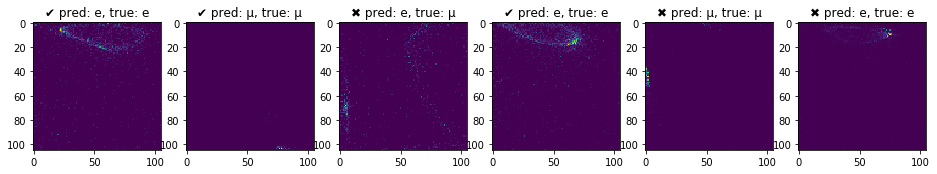

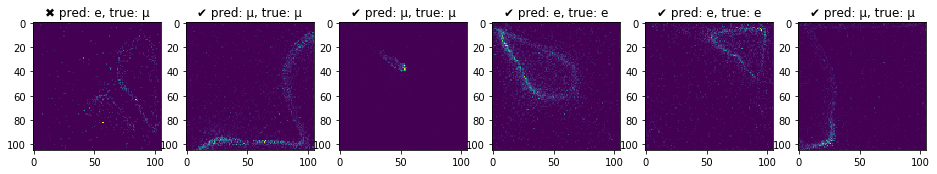

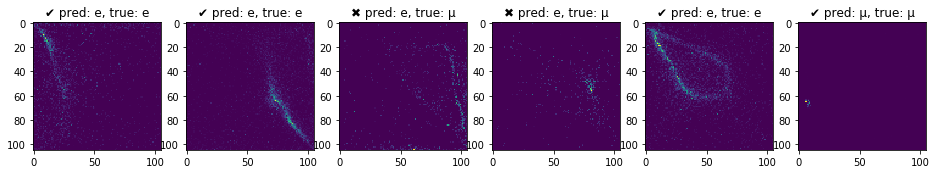

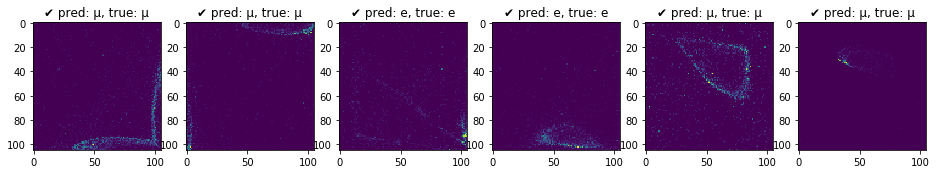

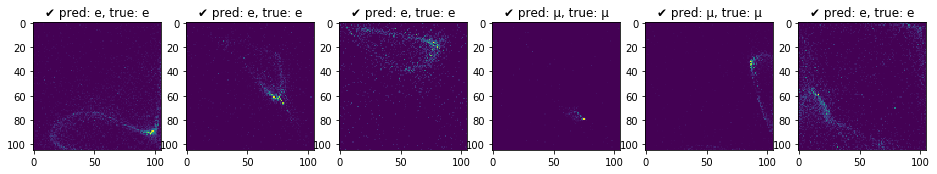

In [10]:
with torch.no_grad():
    Nrows = 5
    for r in range(Nrows):
        Nplot = 6
        fig, axes = plt.subplots(1, Nplot, figsize=(16,3),facecolor='w')

        with torch.no_grad():
            blob.net.eval()
            test_data = next(iter(test_loader))
            
            # Data and label
            blob.data  = test_data['event_data']
            blob.label = test_data['label']
            # blob.energies = test_data['energies']
            
            blob.data  = blob.data[0:Nplot,:,:,0:1] # last 0:1 selects charge channel only
            blob.label = blob.label[0:Nplot]
            res = forward(blob,False)

            for ev in range(Nplot):
                im = axes[ev].imshow(blob.data[ev,:,:,0])
                labelNames = ['e','μ','π+']
                prediction = np.argmax(res['softmax'][:,0:2], axis=1) # we use 0:2 to only classify between e and mu
                correct = (blob.label[ev] == res['prediction'][ev])
                axes[ev].set_title('%s pred: %s, true: %s' % ('✔︎' if correct else '✖︎', labelNames[prediction[ev]], labelNames[blob.label[ev]]))
                #cbar = fig.colorbar(im, ax=axes[ev])
            plt.show()
            
            del test_data
            del blob.data
            del blob.label

In [11]:
evts = {
    'true': {
        'label': [],
        'positions': [],
        'directions': [],
        'energies': []
    },
    'reco': {
        'label': []
    }
};

with torch.no_grad():
    Nrows = 5
    with torch.no_grad():
        blob.net.eval()
        for test_data in iter(test_loader):
            # Data and label
            blob.data  = test_data['event_data']
            blob.label = test_data['label']
            # blob.energies = test_data['energies']
            
            blob.data  = blob.data[:,:,:,0:1] # last 0:1 selects charge channel only
            blob.label = blob.label
            res = forward(blob,False) # False = don't train

            for ev in range(blob.data.shape[0]):
                evts['true']['label'].append(blob.label[ev])
                evts['true']['positions'].append(test_data['positions'][ev,0,:])   # 0=particle1, :=spatial coords
                evts['true']['directions'].append(test_data['directions'][ev,0,:]) # 0=particle1, :=spatial coords
                evts['true']['energies'].append(test_data['energies'][ev,0])       # 0=particle1
                # labelNames = ['e','μ','π+']
                prediction = np.argmax(res['softmax'][:,0:2], axis=1) # we use 0:2 to only classify between e and mu
                evts['reco']['label'].append(prediction[ev])
            
            del test_data
            del blob.data
            del blob.label

In [12]:
evts_correct = {
    'true': {
        'label': [evts['true']['label'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['label'][i] == evts['reco']['label'][i]],
        'energies': [evts['true']['energies'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['label'][i] == evts['reco']['label'][i]],
        'positions': [evts['true']['positions'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['label'][i] == evts['reco']['label'][i]],
        'directions': [evts['true']['directions'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['label'][i] == evts['reco']['label'][i]]
    },
    'reco': {
        'label': [evts['reco']['label'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['label'][i] == evts['reco']['label'][i]],
    }
};

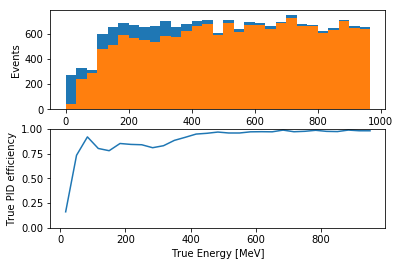

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)

hist_all = plt.hist(evts['true']['energies'], bins=np.arange(30)/30.*1000.)
hist_correct = plt.hist(evts_correct['true']['energies'], bins=hist_all[1])
ax1.set_xlabel("True Energy [MeV]")
ax1.set_ylabel("Events")

ax2 = fig.add_subplot(2,1,2)
hist_eff = hist_correct[0] / hist_all[0]
nbins = len(hist_eff)

ax2.plot((hist_all[1][0:nbins] + hist_all[1][1:nbins+1])/2.,hist_eff)
ax2.set_ylim(0,1)
ax2.set_xlabel("True Energy [MeV]")
ax2.set_ylabel("True PID efficiency")

plt.show()

In [14]:
evts['true']['dirx'] = [evts['true']['directions'][i][0] for i in range(len(evts['true']['directions']))]
evts['true']['diry'] = [evts['true']['directions'][i][1] for i in range(len(evts['true']['directions']))]
evts['true']['dirz'] = [evts['true']['directions'][i][2] for i in range(len(evts['true']['directions']))]

evts_correct['true']['dirx'] = [evts_correct['true']['directions'][i][0] for i in range(len(evts_correct['true']['directions']))]
evts_correct['true']['diry'] = [evts_correct['true']['directions'][i][1] for i in range(len(evts_correct['true']['directions']))]
evts_correct['true']['dirz'] = [evts_correct['true']['directions'][i][2] for i in range(len(evts_correct['true']['directions']))]

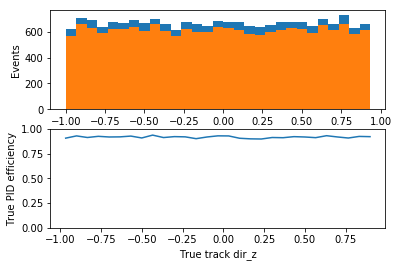

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)

hist_all = plt.hist(evts['true']['dirz'], bins=(2.*np.arange(30)/30. - 1.))
hist_correct = plt.hist(evts_correct['true']['dirz'], bins=hist_all[1])
ax1.set_xlabel("True track dir_z")
ax1.set_ylabel("Events")

ax2 = fig.add_subplot(2,1,2)
hist_eff = hist_correct[0] / hist_all[0]
nbins = len(hist_eff)

ax2.plot((hist_all[1][0:nbins] + hist_all[1][1:nbins+1])/2.,hist_eff)
ax2.set_ylim(0,1)
ax2.set_xlabel("True track dir_z")
ax2.set_ylabel("True PID efficiency")

plt.show()

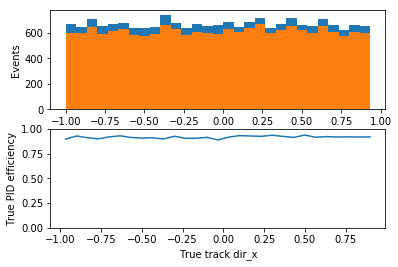

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)

hist_all = plt.hist(evts['true']['dirx'], bins=(2.*np.arange(30)/30. - 1.))
hist_correct = plt.hist(evts_correct['true']['dirx'], bins=hist_all[1])
ax1.set_xlabel("True track dir_x")
ax1.set_ylabel("Events")

ax2 = fig.add_subplot(2,1,2)
hist_eff = hist_correct[0] / hist_all[0]
nbins = len(hist_eff)

ax2.plot((hist_all[1][0:nbins] + hist_all[1][1:nbins+1])/2.,hist_eff)
ax2.set_ylim(0,1)
ax2.set_xlabel("True track dir_x")
ax2.set_ylabel("True PID efficiency")

plt.show()

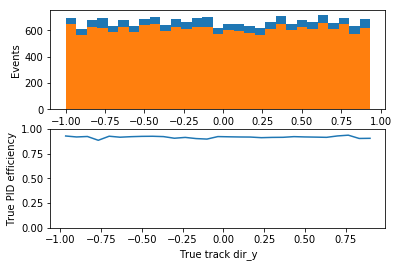

In [17]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)

hist_all = plt.hist(evts['true']['diry'], bins=(2.*np.arange(30)/30. - 1.))
hist_correct = plt.hist(evts_correct['true']['diry'], bins=hist_all[1])
ax1.set_xlabel("True track dir_y")
ax1.set_ylabel("Events")

ax2 = fig.add_subplot(2,1,2)
hist_eff = hist_correct[0] / hist_all[0]
nbins = len(hist_eff)

ax2.plot((hist_all[1][0:nbins] + hist_all[1][1:nbins+1])/2.,hist_eff)
ax2.set_ylim(0,1)
ax2.set_xlabel("True track dir_y")
ax2.set_ylabel("True PID efficiency")

plt.show()

interestingly, we do not observe any noticable gap. Maybe we should plot >500MeV only (because tagging eff is high there)

In [28]:
evts_HE = {
    'true': {
        'label': [evts['true']['label'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['energies'][i] > 500.],
        'energies': [evts['true']['energies'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['energies'][i] > 500.],
        'positions': [evts['true']['positions'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['energies'][i] > 500.],
        'directions': [evts['true']['directions'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['energies'][i] > 500.],
        'dirx': [evts['true']['dirx'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['energies'][i] > 500.],
        'diry': [evts['true']['diry'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['energies'][i] > 500.],
        'dirz': [evts['true']['dirz'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['energies'][i] > 500.],
    },
    'reco': {
        'label': [evts['reco']['label'][i] for i in range(len(evts['true']['label']))  
                              if evts['true']['energies'][i] > 500.],
    }
};

evts_HE_correct = {
    'true': {
        'label': [evts_HE['true']['label'][i] for i in range(len(evts_HE['true']['label']))  
                              if evts_HE['true']['label'][i] == evts_HE['reco']['label'][i]],
        'energies': [evts_HE['true']['energies'][i] for i in range(len(evts_HE['true']['label']))  
                              if evts_HE['true']['label'][i] == evts_HE['reco']['label'][i]],
        'positions': [evts_HE['true']['positions'][i] for i in range(len(evts_HE['true']['label']))  
                              if evts_HE['true']['label'][i] == evts_HE['reco']['label'][i]],
        'directions': [evts_HE['true']['directions'][i] for i in range(len(evts_HE['true']['label']))  
                              if evts_HE['true']['label'][i] == evts_HE['reco']['label'][i]],
        'dirx': [evts_HE['true']['dirx'][i] for i in range(len(evts_HE['true']['label']))  
                              if evts_HE['true']['label'][i] == evts_HE['reco']['label'][i]],
        'diry': [evts_HE['true']['diry'][i] for i in range(len(evts_HE['true']['label']))  
                              if evts_HE['true']['label'][i] == evts_HE['reco']['label'][i]],
        'dirz': [evts_HE['true']['dirz'][i] for i in range(len(evts_HE['true']['label']))  
                              if evts_HE['true']['label'][i] == evts_HE['reco']['label'][i]],
    },
    'reco': {
        'label': [evts_HE['reco']['label'][i] for i in range(len(evts_HE['true']['label']))  
                              if evts_HE['true']['label'][i] == evts_HE['reco']['label'][i]],
    }
};

In [29]:
print(len(evts['true']['label']))
print(len(evts_correct['true']['label']))
print(len(evts_HE['true']['label']))
print(len(evts_HE_correct['true']['label']))

20000
18359
11148
10877


(array([1134., 1102., 1148., 1037., 1106., 1100., 1093., 1124., 1194.,
        1110.]),
 array([-9.9983478e-01, -7.9986960e-01, -5.9990436e-01, -3.9993918e-01,
        -1.9997397e-01, -8.7618828e-06,  1.9995645e-01,  3.9992166e-01,
         5.9988683e-01,  7.9985207e-01,  9.9981725e-01], dtype=float32),
 <a list of 10 Patch objects>)

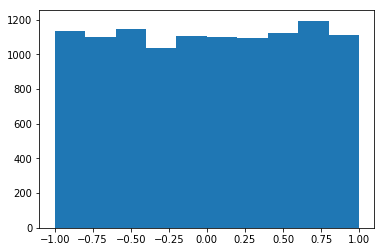

In [30]:
plt.hist(evts_HE['true']['dirz'])

(array([1854., 1829., 1905., 1792., 1827., 1824., 1786., 1831., 1925.,
        1786.]),
 array([-9.9995923e-01, -7.9996532e-01, -5.9997141e-01, -3.9997748e-01,
        -1.9998355e-01,  1.0371208e-05,  2.0000429e-01,  3.9999822e-01,
         5.9999216e-01,  7.9998606e-01,  9.9997997e-01], dtype=float32),
 <a list of 10 Patch objects>)

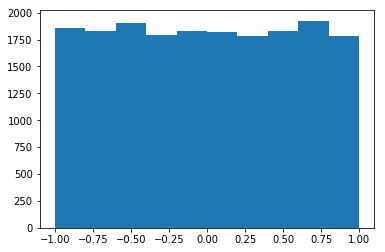

In [31]:
plt.hist(evts_correct['true']['dirz'])

(array([1098., 1077., 1133., 1008., 1083., 1075., 1063., 1097., 1164.,
        1079.]),
 array([-9.9983478e-01, -7.9986960e-01, -5.9990436e-01, -3.9993918e-01,
        -1.9997397e-01, -8.7618828e-06,  1.9995645e-01,  3.9992166e-01,
         5.9988683e-01,  7.9985207e-01,  9.9981725e-01], dtype=float32),
 <a list of 10 Patch objects>)

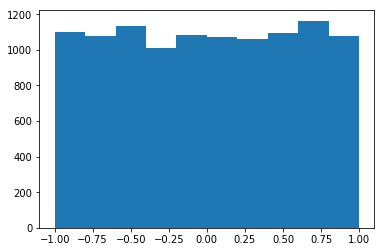

In [32]:
plt.hist(evts_HE_correct['true']['dirz'])

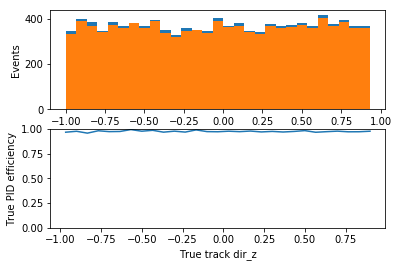

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)

hist_all = plt.hist(evts_HE['true']['dirz'], bins=(2.*np.arange(30)/30. - 1.))
hist_correct = plt.hist(evts_HE_correct['true']['dirz'], bins=hist_all[1])
ax1.set_xlabel("True track dir_z")
ax1.set_ylabel("Events")

ax2 = fig.add_subplot(2,1,2)
hist_eff = hist_correct[0] / hist_all[0]
nbins = len(hist_eff)

ax2.plot((hist_all[1][0:nbins] + hist_all[1][1:nbins+1])/2.,hist_eff)
ax2.set_ylim(0,1)
ax2.set_xlabel("True track dir_z")
ax2.set_ylabel("True PID efficiency")

plt.show()

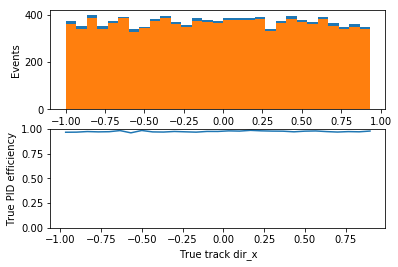

In [34]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)

hist_all = plt.hist(evts_HE['true']['dirx'], bins=(2.*np.arange(30)/30. - 1.))
hist_correct = plt.hist(evts_HE_correct['true']['dirx'], bins=hist_all[1])
ax1.set_xlabel("True track dir_x")
ax1.set_ylabel("Events")

ax2 = fig.add_subplot(2,1,2)
hist_eff = hist_correct[0] / hist_all[0]
nbins = len(hist_eff)

ax2.plot((hist_all[1][0:nbins] + hist_all[1][1:nbins+1])/2.,hist_eff)
ax2.set_ylim(0,1)
ax2.set_xlabel("True track dir_x")
ax2.set_ylabel("True PID efficiency")

plt.show()